In [45]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from numba import njit
import cvxpy as cp
from cvxpy.problems.problem import Problem, Minimize

%matplotlib inline

In [5]:
img = plt.imread('flower.jpg')

In [6]:
h, w = 40, 50
img = skimage.transform.resize(img, (h, w))
img = np.clip(img, 0, 1)

In [7]:
f_idx = np.array([(20, 18), (20, 30), (10, 20)]) #foreground idxs
b_idx = np.array([(5, 5), (35,35), (10, 40), (30,10)]) #background idxs

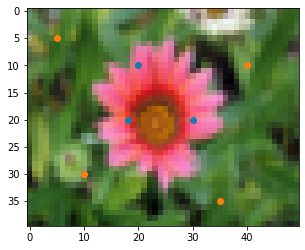

In [8]:
plt.imshow(img)
plt.scatter(f_idx[:, 1], f_idx[:, 0])
plt.scatter(b_idx[:, 1], b_idx[:, 0])

In [29]:
scale_coord = 1.4
xx = np.arange(img.shape[1], dtype='d')/img.shape[1]/scale_coord
yy = np.arange(img.shape[0], dtype='d')/img.shape[0]/scale_coord
coords = np.meshgrid(xx, yy)

In [30]:
new_img = np.stack([img[:,:,0], img[:,:,1], img[:,:,2], coords[0], coords[1]], axis=2) #stack coordinate and color values

In [37]:
@njit
def get_adjacency_matrix(img):
    """
    Compute adjacency matrix for given image with linear kernel.
    njit for accelerating speed
    
    Parameters:
    --------
    img : (h, w, ...) array_like
        Input image for computing
    
    Returns:
    --------
    A : (h*w, h*w) array_like
        Adjacency matrix of img
    
    """
    N = img.shape[0]*img.shape[1]
    X = img.reshape((N, -1))
    S = X@X.T
    b = np.diag(S)
    A = b.reshape(1, -1) - 2*S + b.reshape(-1, 1) #||x_i-x_j||^2=(x_i, x_i)-2*(x_i, x_j)+(x_j, x_j)
    return A

def coord_to_flatten_idx(y, x, h=h, w=w):
    """
    By coordinate of pixel of original image return single index of flatten array
    """
    assert y < h and x < w, 'Wrond indexes'
    return y*w+x

def flatten_idx_to_coors(idx, h=h, w=w):
    """
    By single index of flatten array return coordinate of pixel of original image
    """
    assert idx < h*w, 'Wrong index'
    return (idx//h, idx%w)

In [40]:
N = new_img.shape[0]*new_img.shape[1]
A = get_adjacency_matrix(new_img)

D = np.diag(A.sum(axis=0)) #Degree matrix
L = np.diag(A.sum(axis=0)) - A #Laplacian matrix

In [46]:
new_f_idx = [coord_to_flatten_idx(*f_idx[i]) for i in range(f_idx.shape[0])]
new_b_idx = [coord_to_flatten_idx(*b_idx[i]) for i in range(b_idx.shape[0])]

I = np.eye(N)
e = np.ones(N)

I_f = np.zeros_like(I)
I_b = np.zeros_like(I)
I_f[new_f_idx, new_f_idx] = 1 
I_b[new_b_idx, new_b_idx] = 1

e_f = np.zeros_like(e)
e_b = np.zeros_like(e)
e_f[new_f_idx] = 1
e_b[new_b_idx] = -1


x = cp.Variable(shape=(N,))
constraints = [I_f@x == e_f, I_b@x == e_b, I@x <= e, I@x >= -e]

In [43]:
objective = cp.Minimize(cp.quad_form(x, L))
problem = cp.Problem(objective, constraints) 

problem.solve()

6285.673664495265

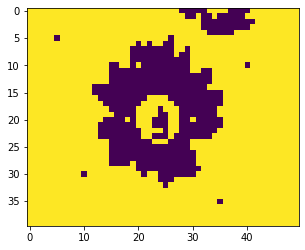

In [44]:
solution = x.value

solution = solution > x.value.mean()

plt.imshow(np.clip(solution.reshape(h, w), 0, 1))